In [33]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
TRAIN_PATH = "data/train_FD004.txt"
TEST_PATH = "data/test_FD004.txt"
RUL_PATH = "data/RUL_FD004.txt"
MODEL_PATH = "best_model_fd004.pth"
SCALER_PATH = "scaler_fd004.pkl"


SEQ_LEN = 80 
STEP = 1
BATCH_SIZE = 128
LR = 5e-4
EPOCHS = 100
PATIENCE = 15
RUL_CAP = 125 # NASA common cap for RUL targets
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42


# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [35]:
def read_cmapss(path):
# load and trim trailing empty columns
    df = pd.read_csv(path, sep=" ", header=None).dropna(axis=1, how="all")
    return df


# ---------------------- LOAD DATA ----------------------
train_raw = read_cmapss(TRAIN_PATH)
test_raw = read_cmapss(TEST_PATH)
rul_raw = read_cmapss(RUL_PATH)


# standard CMAPSS columns (FD files have 26 columns typically after dropna)
cols = ["unit", "cycle"] + [f"op_setting_{i}" for i in range(1,4)] + [f"sensor_{i}" for i in range(1,22)]
train_raw = train_raw.iloc[:, :len(cols)]
train_raw.columns = cols


test_raw = test_raw.iloc[:, :len(cols)]
test_raw.columns = cols

In [36]:
# I've chosen the commonly used informative sensors for FD004 (keeps noise low)
selected_features = [
"op_setting_1","op_setting_2","op_setting_3",
"sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
"sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]


# Keep only cols of interest + unit,cycle
train_df = train_raw[["unit","cycle"] + selected_features].copy()
# We'll compute RUL next


# ---------------------- COMPUTE RUL (TRAIN) WITH CAPPING ----------------------
# RUL per row: remaining cycles until failure for engines in train set
train_max = train_raw.groupby("unit")["cycle"].max().to_dict()
train_df["RUL"] = train_df.apply(lambda r: train_max[r["unit"]] - r["cycle"], axis=1)
train_df["RUL"] = train_df["RUL"].clip(upper=RUL_CAP)


# ---------------------- TEST RULs (from provided RUL file) ----------------------
rul_vals = rul_raw.iloc[:,0].values.flatten()
# map engine->true remaining cycles (for test units in order)
test_units = sorted(test_raw["unit"].unique())
test_rul_map = {u: int(r) for u, r in zip(test_units, rul_vals)}


# Prepare test dataframe with features
test_df = test_raw[["unit","cycle"] + selected_features].copy()

In [37]:
scaler = StandardScaler()
scaler.fit(train_df[selected_features].values)
train_df[selected_features] = scaler.transform(train_df[selected_features].values)
# Apply same scaler on test
test_df[selected_features] = scaler.transform(test_df[selected_features].values)


# Save scaler for later inference
with open(SCALER_PATH, "wb") as f:
    pickle.dump(scaler, f)
print("Saved scaler to", SCALER_PATH)

Saved scaler to scaler_fd004.pkl


In [38]:
def create_sequences_by_units(df, units_list, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in units_list:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df["RUL"].values
        L = len(unit_df)
        if L < seq_len:
    # pad at front with first row (rare), ensures consistent length
            pad_len = seq_len - L
            pad = np.repeat(feats[[0]], pad_len, axis=0)
            feats_pad = np.vstack([pad, feats])
            # label corresponds to last time (end)
            X.append(feats_pad.astype(np.float32))
            y.append(labels[-1])
        else:
            for start in range(0, L - seq_len + 1, step):
                end = start + seq_len
                X.append(feats[start:end].astype(np.float32))
                y.append(labels[end-1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [39]:
units = sorted(train_df["unit"].unique())
n_units = len(units)
train_units = units[: int(n_units * 0.8)]
val_units = units[int(n_units * 0.8):]


X_train, y_train = create_sequences_by_units(train_df, train_units, SEQ_LEN, STEP)
X_val, y_val = create_sequences_by_units(train_df, val_units, SEQ_LEN, STEP)


print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_val", X_val.shape, "y_val", y_val.shape)

X_train (33351, 80, 14) y_train (33351,)
X_val (8227, 80, 14) y_val (8227,)


In [40]:
# Build test last-window per engine
def build_test_last_windows(test_df, rul_map, seq_len=SEQ_LEN):
    X_test = []
    y_test = []
    units_sorted = sorted(test_df["unit"].unique())
    for uid in units_sorted:
        unit_df = test_df[test_df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        if len(unit_df) < seq_len:
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(feats[[0]], pad_len, axis=0)
            window = np.vstack([pad, feats])
        else:
            window = feats[-seq_len:]
        X_test.append(window.astype(np.float32))
        y_test.append(min(rul_map[uid], RUL_CAP))
    return np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.float32), units_sorted


X_test, y_test, test_units = build_test_last_windows(test_df, test_rul_map, SEQ_LEN)
print("X_test", X_test.shape, "y_test", y_test.shape)

X_test (248, 80, 14) y_test (248,)


In [41]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SeqDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SeqDataset(X_test, y_test), batch_size=64, shuffle=False)

In [42]:
class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Tanh(),
            nn.Linear(dim, 1)
            )
    def forward(self, x):
        # x: (batch, seq, hidden)
        w = self.attn(x) # (batch, seq, 1)
        w = torch.softmax(w, dim=1) # softmax over seq
        out = (x * w).sum(dim=1) # weighted sum -> (batch, hidden)
        return out


class SmallModel(nn.Module):
    def __init__(self, input_dim, cnn_filters=64, lstm_hidden=128, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers>1 else 0.0
            )
        self.attn = Attention(2 * lstm_hidden)
        self.fc = nn.Sequential(
            nn.Linear(2 * lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
            )
    def forward(self, x):
    # x: (B, T, F)
        x = x.permute(0,2,1) # (B, F, T) for Conv1d
        x = self.cnn(x)
        x = x.permute(0,2,1) # (B, T, C)
        x, _ = self.lstm(x)
        x = self.attn(x)
        return self.fc(x)

In [43]:
# Instantiate model
model = SmallModel(input_dim=len(selected_features)).to(DEVICE)
print(model)

SmallModel(
  (cnn): Conv1d(14, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attn): Attention(
    (attn): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:

# ---------------------- TRAINING ----------------------
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4)

best_val = float('inf')
wait = 0
train_hist = { 'train_loss':[], 'val_loss':[], 'train_mae':[], 'val_mae':[] }

for epoch in range(1, EPOCHS+1):
    model.train()
    t_loss = 0.0
    t_mae  = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * Xb.size(0)
        t_mae  += torch.nn.functional.l1_loss(pred, yb, reduction='sum').item()
    t_loss /= len(train_loader.dataset)
    t_mae  /= len(train_loader.dataset)

    # validation
    model.eval()
    v_loss = 0.0
    v_mae  = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            pred = model(Xb)
            v_loss += criterion(pred, yb).item() * Xb.size(0)
            v_mae  += torch.nn.functional.l1_loss(pred, yb, reduction='sum').item()
    v_loss /= len(val_loader.dataset)
    v_mae  /= len(val_loader.dataset)

    scheduler.step(v_loss)

    train_hist['train_loss'].append(t_loss)
    train_hist['val_loss'].append(v_loss)
    train_hist['train_mae'].append(t_mae)
    train_hist['val_mae'].append(v_mae)

    print(f"Epoch {epoch:03d} | Train Loss {t_loss:.4f} | Val Loss {v_loss:.4f} | Train MAE {t_mae:.4f} | Val MAE {v_mae:.4f}")

    if v_loss < best_val - 1e-6:
        best_val = v_loss
        wait = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("  -> New best model saved")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping at epoch {epoch}. Best epoch saved.")
            break

# load best model
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()



In [ ]:

preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb).cpu().numpy().flatten()
        preds.extend(out.tolist())
preds = np.array(preds)

# y_test created earlier is clipped to RUL_CAP
rmse = math.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print(f"Test RMSE: {rmse:.4f}  MAE: {mae:.4f}")



Test RMSE: 16.4780  MAE: 11.0227


In [ ]:

# print per-engine short table (first 30 for brevity)
print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(test_units[:60], y_test[:60], preds[:60]):
    print(f"{u:3d}     {t:7.2f}     {p:7.2f}")



Engine | True RUL | Predicted RUL
  1       22.00       25.14
  2       39.00       41.06
  3      107.00      103.91
  4       75.00       72.15
  5      125.00      108.56
  6       78.00      105.44
  7       94.00      112.72
  8       14.00       16.92
  9       99.00      111.71
 10      125.00      124.82
 11      125.00      126.41
 12        7.00        6.59
 13       71.00       89.28
 14      105.00       72.59
 15       12.00       18.91
 16      125.00      123.03
 17      125.00       98.62
 18      104.00       98.30
 19      125.00      128.30
 20       82.00      115.20
 21       91.00       79.19
 22       11.00       14.67
 23       26.00       33.41
 24      125.00      113.46
 25       39.00       44.71
 26       92.00      113.69
 27       76.00       88.80
 28      124.00      126.24
 29       64.00       69.81
 30      118.00       85.03
 31        6.00        8.14
 32       22.00       14.98
 33      125.00      120.67
 34      125.00       72.71
 35       36.

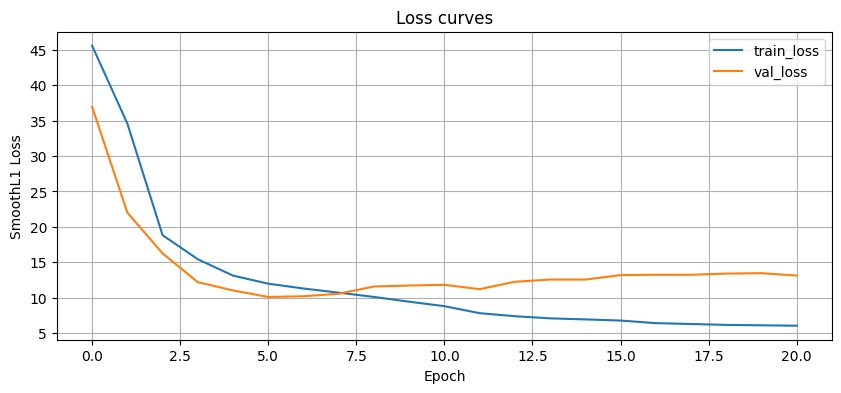

In [ ]:

# plots
plt.figure(figsize=(10,4))
plt.plot(train_hist['train_loss'], label='train_loss')
plt.plot(train_hist['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SmoothL1 Loss')
plt.legend()
plt.grid(True)
plt.title('Loss curves')
plt.show()


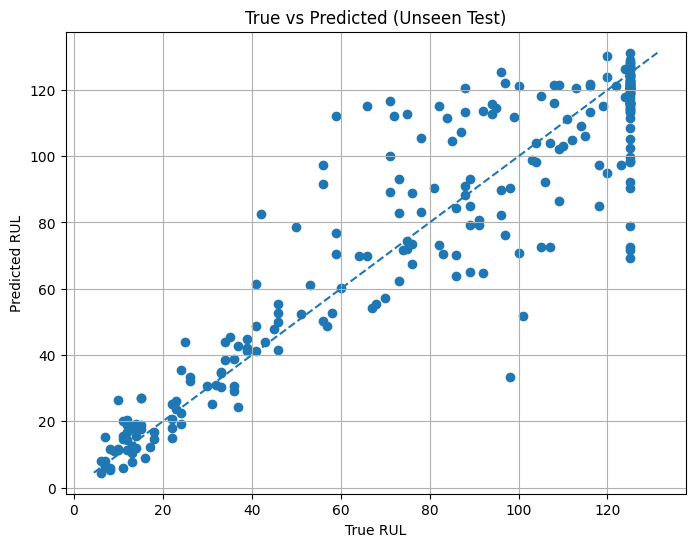

In [ ]:

plt.figure(figsize=(8,6))
plt.scatter(y_test, preds)
mn = min(y_test.min(), preds.min())
mx = max(y_test.max(), preds.max())
plt.plot([mn,mx],[mn,mx],'--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted (Unseen Test)')
plt.grid(True)
plt.show()



In [ ]:
## unseen data testing 

In [45]:
with open("scaler_fd004.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

In [46]:
import torch
import torch.nn as nn

selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]

class SmallModel(nn.Module):
    def __init__(self, input_dim, cnn_filters=64, lstm_hidden=128, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers>1 else 0.0
            )
        self.attn = Attention(2 * lstm_hidden)
        self.fc = nn.Sequential(
            nn.Linear(2 * lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
            )
    def forward(self, x):
    # x: (B, T, F)
        x = x.permute(0,2,1) # (B, F, T) for Conv1d
        x = self.cnn(x)
        x = x.permute(0,2,1) # (B, T, C)
        x, _ = self.lstm(x)
        x = self.attn(x)
        return self.fc(x) 





In [47]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallModel(input_dim=len(selected_features)).to(DEVICE)
model.load_state_dict(torch.load("best_model_fd004.pth", map_location=device))


print("Loaded model successfully!")

Loaded model successfully!


In [54]:
model.eval()
preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb)                 # shape (batch,1)
        preds.extend(out.cpu().numpy().flatten())

preds = np.array(preds).flatten()
# preds correspond to engines in test_units order
# y_test we built earlier is clipped RUL from rul_map; use that for metric
y_true = y_test.copy()

# compute RMSE (per-engine)
rmse = math.sqrt(mean_squared_error(y_true, preds))
print(f"TEST RMSE (per-engine): {rmse:.6f}")

TEST RMSE (per-engine): 16.478000


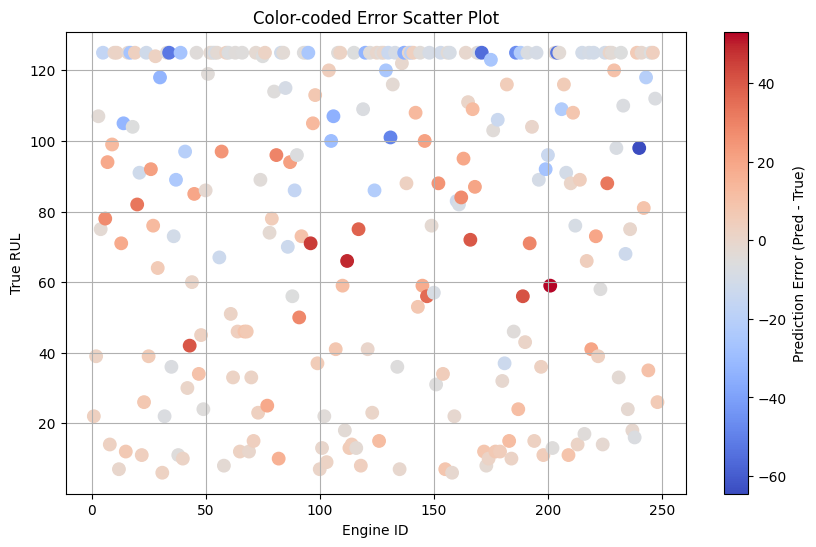

In [49]:
errors = preds - y_true

plt.figure(figsize=(10,6))
plt.scatter(test_units, y_true, c=errors, cmap="coolwarm", s=80)
plt.colorbar(label="Prediction Error (Pred - True)")
plt.xlabel("Engine ID")
plt.ylabel("True RUL")
plt.title("Color-coded Error Scatter Plot")
plt.grid(True)
plt.show()


In [76]:
# %%
UNSEEN_PATH = "data/test_FD004.txt"
UNSEEN_TRUE_RUL_PATH = "data/RUL_FD004.txt"   # Must contain RUL values line-by-line

# Load unseen dataset
unseen_df = pd.read_csv(UNSEEN_PATH, sep=" ", header=None).dropna(axis=1, how="all")
unseen_df = unseen_df.iloc[:, :len(cols)]
unseen_df.columns = cols

# Keep only features
unseen_df = unseen_df[["unit","cycle"] + selected_features]

# Apply saved scaler
unseen_df[selected_features] = loaded_scaler.transform(unseen_df[selected_features])

print(unseen_df.head())


   unit  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_2  sensor_3  \
0     1      1     -0.270126      0.414074      0.418783  0.729733  0.594757   
1     1      2      0.067560      0.156591     -2.387873 -1.156865 -1.523327   
2     1      3      1.217824      0.871105      0.418783 -0.808467 -0.732495   
3     1      4      1.218061      0.865312      0.418783 -0.809538 -0.736545   
4     1      5      0.744765      0.864668      0.418783 -0.651273 -0.610894   

   sensor_4  sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  \
0  0.217006  0.334911  0.653498  0.535154   0.294583   0.334308   0.416176   
1 -1.428310 -0.741213 -2.156742 -1.557420  -2.085587  -0.744708  -2.389588   
2 -0.804811 -0.993938 -0.115283 -0.650867  -0.417618  -0.987563   0.417502   
3 -0.793246 -0.994687 -0.115558 -0.663867  -0.352872  -0.991173   0.417112   
4 -0.704917 -0.615395 -0.041116 -0.574678  -0.479280  -0.613207   0.416878   

   sensor_14  sensor_15  
0  -0.219818  -0.083564 

c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [77]:
# Build sequences for unseen data
X_unseen, unseen_units = build_unseen_last_windows(unseen_df, SEQ_LEN)

print("Unseen windows:", X_unseen.shape)
print("Unique unseen units:", len(unseen_units))


Unseen windows: (248, 80, 14)
Unique unseen units: 248


In [78]:
unseen_loader = DataLoader(
    torch.tensor(X_unseen, dtype=torch.float32),
    batch_size=64,
    shuffle=False
)


In [79]:
model.eval()
unseen_preds = []

with torch.no_grad():
    for Xb in unseen_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb).cpu().numpy().flatten()
        unseen_preds.extend(out)

unseen_preds = np.array(unseen_preds)
print("Predictions for unseen:", unseen_preds.shape)


Predictions for unseen: (248,)


In [80]:
actual_unseen = np.loadtxt(UNSEEN_TRUE_RUL_PATH)

# Apply same RUL cap (if you used 130)
actual_unseen = np.array([min(r, RUL_CAP) for r in actual_unseen])

print("Actual unseen RUL shape:", actual_unseen.shape)


Actual unseen RUL shape: (248,)


In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

rmse_unseen = math.sqrt(mean_squared_error(actual_unseen, unseen_preds))
mae_unseen = mean_absolute_error(actual_unseen, unseen_preds)

print("Unseen RMSE:", rmse_unseen)
print("Unseen MAE :", mae_unseen)


Unseen RMSE: 16.47799949111712
Unseen MAE : 11.022710536756824


In [83]:
print("\nActual vs Predicted RUL for unseen engines:")
for uid, pred, act in zip(unseen_units, preds, actual_unseen):
    print(f"Engine {uid:3d} ➝ Actual RUL: {act:.2f} | Predicted RUL: {pred:.2f}")



Actual vs Predicted RUL for unseen engines:
Engine   1 ➝ Actual RUL: 22.00 | Predicted RUL: 25.14
Engine   2 ➝ Actual RUL: 39.00 | Predicted RUL: 41.06
Engine   3 ➝ Actual RUL: 107.00 | Predicted RUL: 103.91
Engine   4 ➝ Actual RUL: 75.00 | Predicted RUL: 72.15
Engine   5 ➝ Actual RUL: 125.00 | Predicted RUL: 108.56
Engine   6 ➝ Actual RUL: 78.00 | Predicted RUL: 105.44
Engine   7 ➝ Actual RUL: 94.00 | Predicted RUL: 112.72
Engine   8 ➝ Actual RUL: 14.00 | Predicted RUL: 16.92
Engine   9 ➝ Actual RUL: 99.00 | Predicted RUL: 111.71
Engine  10 ➝ Actual RUL: 125.00 | Predicted RUL: 124.82
Engine  11 ➝ Actual RUL: 125.00 | Predicted RUL: 126.41
Engine  12 ➝ Actual RUL: 7.00 | Predicted RUL: 6.59
Engine  13 ➝ Actual RUL: 71.00 | Predicted RUL: 89.28
Engine  14 ➝ Actual RUL: 105.00 | Predicted RUL: 72.59
Engine  15 ➝ Actual RUL: 12.00 | Predicted RUL: 18.91
Engine  16 ➝ Actual RUL: 125.00 | Predicted RUL: 123.03
Engine  17 ➝ Actual RUL: 125.00 | Predicted RUL: 98.62
Engine  18 ➝ Actual RUL:

In [86]:
# Load true RUL values for unseen data
true_rul_df = pd.read_csv(UNSEEN_TRUE_RUL_PATH, header=None, names=["RUL"])

# Verify length match
print("Predictions:", len(preds), " True RUL:", len(true_rul_df))

# Print comparison
print("\nPredicted vs Actual RUL for unseen engines:")
for uid, pred, actual in zip(unseen_units, preds, true_rul_df["RUL"]):
    print(f"Engine {uid:3d} ➝ Predicted: {pred:.2f} | Actual: {actual:.2f}")


Predictions: 248  True RUL: 248

Predicted vs Actual RUL for unseen engines:
Engine   1 ➝ Predicted: 25.14 | Actual: 22.00
Engine   2 ➝ Predicted: 41.06 | Actual: 39.00
Engine   3 ➝ Predicted: 103.91 | Actual: 107.00
Engine   4 ➝ Predicted: 72.15 | Actual: 75.00
Engine   5 ➝ Predicted: 108.56 | Actual: 149.00
Engine   6 ➝ Predicted: 105.44 | Actual: 78.00
Engine   7 ➝ Predicted: 112.72 | Actual: 94.00
Engine   8 ➝ Predicted: 16.92 | Actual: 14.00
Engine   9 ➝ Predicted: 111.71 | Actual: 99.00
Engine  10 ➝ Predicted: 124.82 | Actual: 162.00
Engine  11 ➝ Predicted: 126.41 | Actual: 143.00
Engine  12 ➝ Predicted: 6.59 | Actual: 7.00
Engine  13 ➝ Predicted: 89.28 | Actual: 71.00
Engine  14 ➝ Predicted: 72.59 | Actual: 105.00
Engine  15 ➝ Predicted: 18.91 | Actual: 12.00
Engine  16 ➝ Predicted: 123.03 | Actual: 160.00
Engine  17 ➝ Predicted: 98.62 | Actual: 162.00
Engine  18 ➝ Predicted: 98.30 | Actual: 104.00
Engine  19 ➝ Predicted: 128.30 | Actual: 194.00
Engine  20 ➝ Predicted: 115.20 | 

In [87]:
comparison_df = pd.DataFrame({
    "EngineID": unseen_units,
    "Predicted_RUL": preds,
    "Actual_RUL": true_rul_df["RUL"]
})

print("\nComparison Table:")
print(comparison_df.head())



Comparison Table:
   EngineID  Predicted_RUL  Actual_RUL
0         1      25.135229          22
1         2      41.061844          39
2         3     103.912216         107
3         4      72.146744          75
4         5     108.558624         149


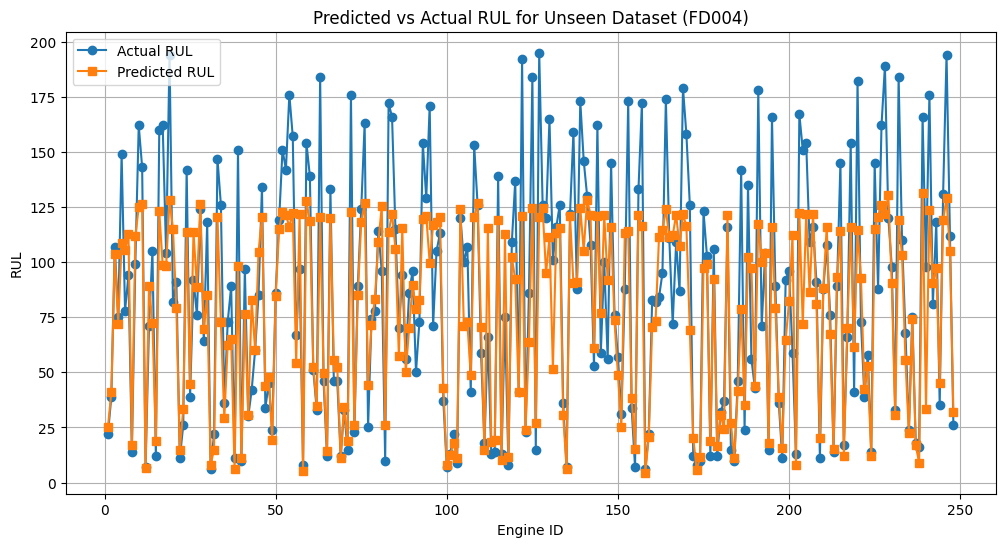

In [88]:
plt.figure(figsize=(12,6))
plt.plot(comparison_df["EngineID"], comparison_df["Actual_RUL"], marker="o", label="Actual RUL")
plt.plot(comparison_df["EngineID"], comparison_df["Predicted_RUL"], marker="s", label="Predicted RUL")

plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.title("Predicted vs Actual RUL for Unseen Dataset (FD004)")
plt.legend()
plt.grid(True)
plt.show()


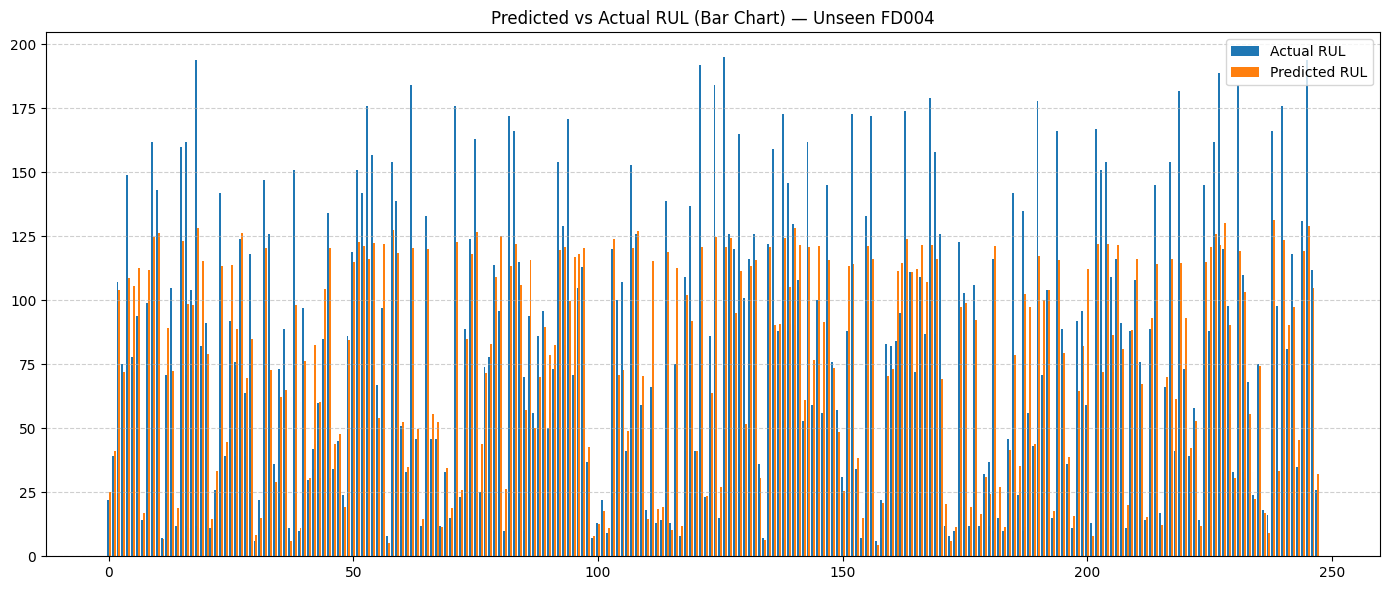

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Width of each bar
bar_width = 0.4

# X locations for engines
x = np.arange(len(comparison_df))

plt.figure(figsize=(14,6))

# Actual RUL bars
plt.bar(x - bar_width/2, comparison_df["Actual_RUL"], 
        width=bar_width, label="Actual RUL")

# Predicted RUL bars
plt.bar(x + bar_width/2, comparison_df["Predicted_RUL"], 
        width=bar_width, label="Predicted RUL")



plt.title("Predicted vs Actual RUL (Bar Chart) — Unseen FD004")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
